## Ignatyev Dmitry B03-904
# Оценка неопределенностей в задаче линейной регрессии

##  -Формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели; формулировка меры неопределенности для параметров модели, меры качества и целевой переменной;


In [1]:
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import datetime
from tqdm import tqdm

plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4

In [2]:
from scipy.stats.stats import pearsonr

In [3]:
# Загрузка данных

X = np.load('X_train.npy')
X_inference = np.load('X_inference.npy')
y = np.load('y_train (1).npy')

In [4]:
print(len(X))
print(len(y))

10000
10000


В данной работе у нас задача типа "обучения с учителем" ( Перейдем к объектам и целевой переменной (функции))


In [5]:
X.shape, y.shape, X_inference.shape

((10000, 4), (10000, 1), (100, 4))

In [6]:
X.dtype, y.dtype

(dtype('float64'), dtype('float64'))

In [7]:
#определим кол-во объектов и кол-во уникальных значений целевой переменной
print(f'количество объектов: {X.shape}')
print(f'количество объектов целевой переменной: {y.shape}')
print(len(np.unique(y)))

количество объектов: (10000, 4)
количество объектов целевой переменной: (10000, 1)
10000


Кол-во объектов равно кол-ву уникальных значений целевой переменной 
=> задача регрессии 
(4 признака и целевая переменная (действительные, рамерность 1))
Функция ошибки - `MSE` , мера качества - `MSE`.
Мера неопределенности качества модели - оценка доверительного интервала для качества модели с уровнем доверия 0.95

### Перейдем к созданию и обучению модели , а так же к исследованию bootstrap-выборок и ее визуализации.

Bootstrap - метод сэмплирования с возвратом:

Определиться с размером bootstrap-выборки Nb
Повторять до тех пор, пока размер bootstrap-выборки не достигнет Nb:
-Выбрать произвольный элемент исходной выборки, "вернуть" его на место.
-Добавить выбранный элемент в bootstrap-выборку.

In [8]:
# оформим в виде класса

class linear_regression:
    def __init__(self):
        self.theta = None
        pass
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
        
        # attaching ones as first column-vector - x[:,0]
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        # making y_train of shape (N,1)
        y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_matrix.T, X_matrix)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_matrix.T)
        theta_star = np.dot(m3, y_column)
        self.theta = theta_star
    
    def predict(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert self.theta is not None, "theta is None. perhaps, fit the model first."
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        y_pred = np.dot(X_matrix, self.theta)
        return y_pred

In [9]:
# Определим также функцию, которая строит визуализацию наших бутстрап-выборок:
def bootstrap_sample_size_plot(X, y, B, sample_size, def_font_size = 6, def_linewidth = 0.5):
    # Генерируем линейную регрессию, получаем параметр Θ:
    theta_bootstrap = []
    for i in tqdm(range(B), total=B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_bootstrap.append(np.copy(lr.theta))
    theta_bsarray = np.concatenate([t.T for t in theta_bootstrap], axis=0)
    
    #А теперь строим график:
    fig = plt.figure(figsize=(4, 6), dpi=300)
    for i in range(theta.shape[0]):
        plt.subplot(3,2, i+1)
        plt.title("$\\theta_%d$" % i, fontdict = {'fontsize': def_font_size})
    
        h_counts, h_bins, P = plt.hist(theta_bsarray[:,i], bins=30, color='white', ec="black", linewidth = def_linewidth)
        mean_theta_i = np.mean(theta_bsarray[:,i])
        std_theta_i = np.std(theta_bsarray[:,i])
    
        plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
        plt.vlines(theta[i,0], 0, h_counts.max(), color='green')
        plt.text(mean_theta_i, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize = def_font_size)
        plt.text(mean_theta_i, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize = def_font_size)
        plt.text(mean_theta_i, 1*h_counts.max()/4, '$\\theta_%d = %.3f$' % (i, theta[i,0]), fontsize = def_font_size, color='green')
    
    plt.tight_layout()

In [10]:
#получим 𝜃 для данных из обуч. выборки
lr = linear_regression()
lr.fit(X,y)

In [11]:
theta = lr.theta
print(theta)

[[-0.98643434]
 [-0.70247201]
 [-0.73652729]
 [ 0.53441968]
 [ 0.08096281]]


### оценим ф-ю потерь для обуч.выборки

In [12]:
y_learn = lr.predict(X)
mean_error_0 = np.mean(y-y_learn)
MSE_0 = np.std((y-y_learn))
print(mean_error_0)
print(MSE_0)

2.5995205987783266e-15
0.7117100500481706


In [13]:
# теперь же сделаем так же на тестовой выборку ( N случ(новых) наборов данных) и ф-ю потерь
N = 1000
random_ind = np.random.permutation(X.shape[0])
random_index = random_ind[: N]

X_test = np.squeeze(X[[random_index],:])
X_00 = np.ones((X_test.shape[0], 1))
y_test = y[random_index]

In [14]:
y_pred = lr.predict(X_test)
mean_error = np.mean(y_pred-y_test)
MSE_test = np.std(y_pred-y_test)
print(mean_error)
print(MSE_test)

-0.005167206310286784
0.7142298693856408


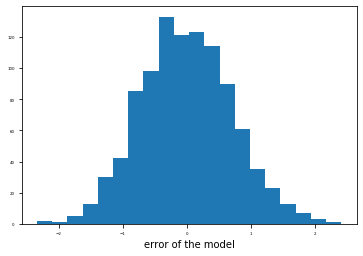

In [15]:
P = plt.hist((y_pred-y_test), bins=20)
P = plt.xlabel('error of the model')

Как видим, функция потерь приблизительно совпала.

По гистограмме распределения функции ошибок модели можно сказать , что при увеличении (N) размера тестовой выборки она будет постепенно стреметься к общему виду нормального распределения , а при малых же значениях будет сильно от нее отличаться из-за небольшого размера тестовой выборки!
(Но при этом пик всегда находиться где-то по центру графика)

#### Исследуем наши данные на предмет скоррелированности!

In [17]:
np.corrcoef(X.T)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

Наши признаки не скоррелированы, всё ок, можно с ними работать

In [156]:
#по строкам и столбцам признаки, с нулевого по третий. По диагонали единицы, т.к. нулевой признак скоррелирован сам с собой (это он и есть)

## Bootstrap

In [103]:
# реализовать функцию bootstrap-сэмплирования
# размер полного массива данных— B точек, а размеры бутстрап-выборок N=10,100,200

def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0, X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices, :], X[oob_indices, :], y[oob_indices, :]
    else:
        return X[sample_indices, :], y[sample_indices, :]

In [104]:
#кол-во бутстрап-выборок (B), размер bootstrap-выборки (Nb)
B = 1000
Nb = 2500

In [105]:
# Определим функцию, которая возвращает массив бутстрап-выборки:

def bootstrap_sample_size(X, y, B, sample_size):
    # Генерируем линейную регрессию, получаем параметр Θ:
    
    theta_bootstrap = []
    for i in tqdm(range(B), total=B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_bootstrap.append(np.copy(lr.theta))
    theta_bsarray = np.concatenate([t.T for t in theta_bootstrap], axis=0)
    return theta_bsarray

In [106]:
# Визуализация вычисления неопределённостей модели на бутстрап-выборках
sample_size = 10
theta_values_curr_sample_size = []

for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11922.58it/s]


In [107]:
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 5)

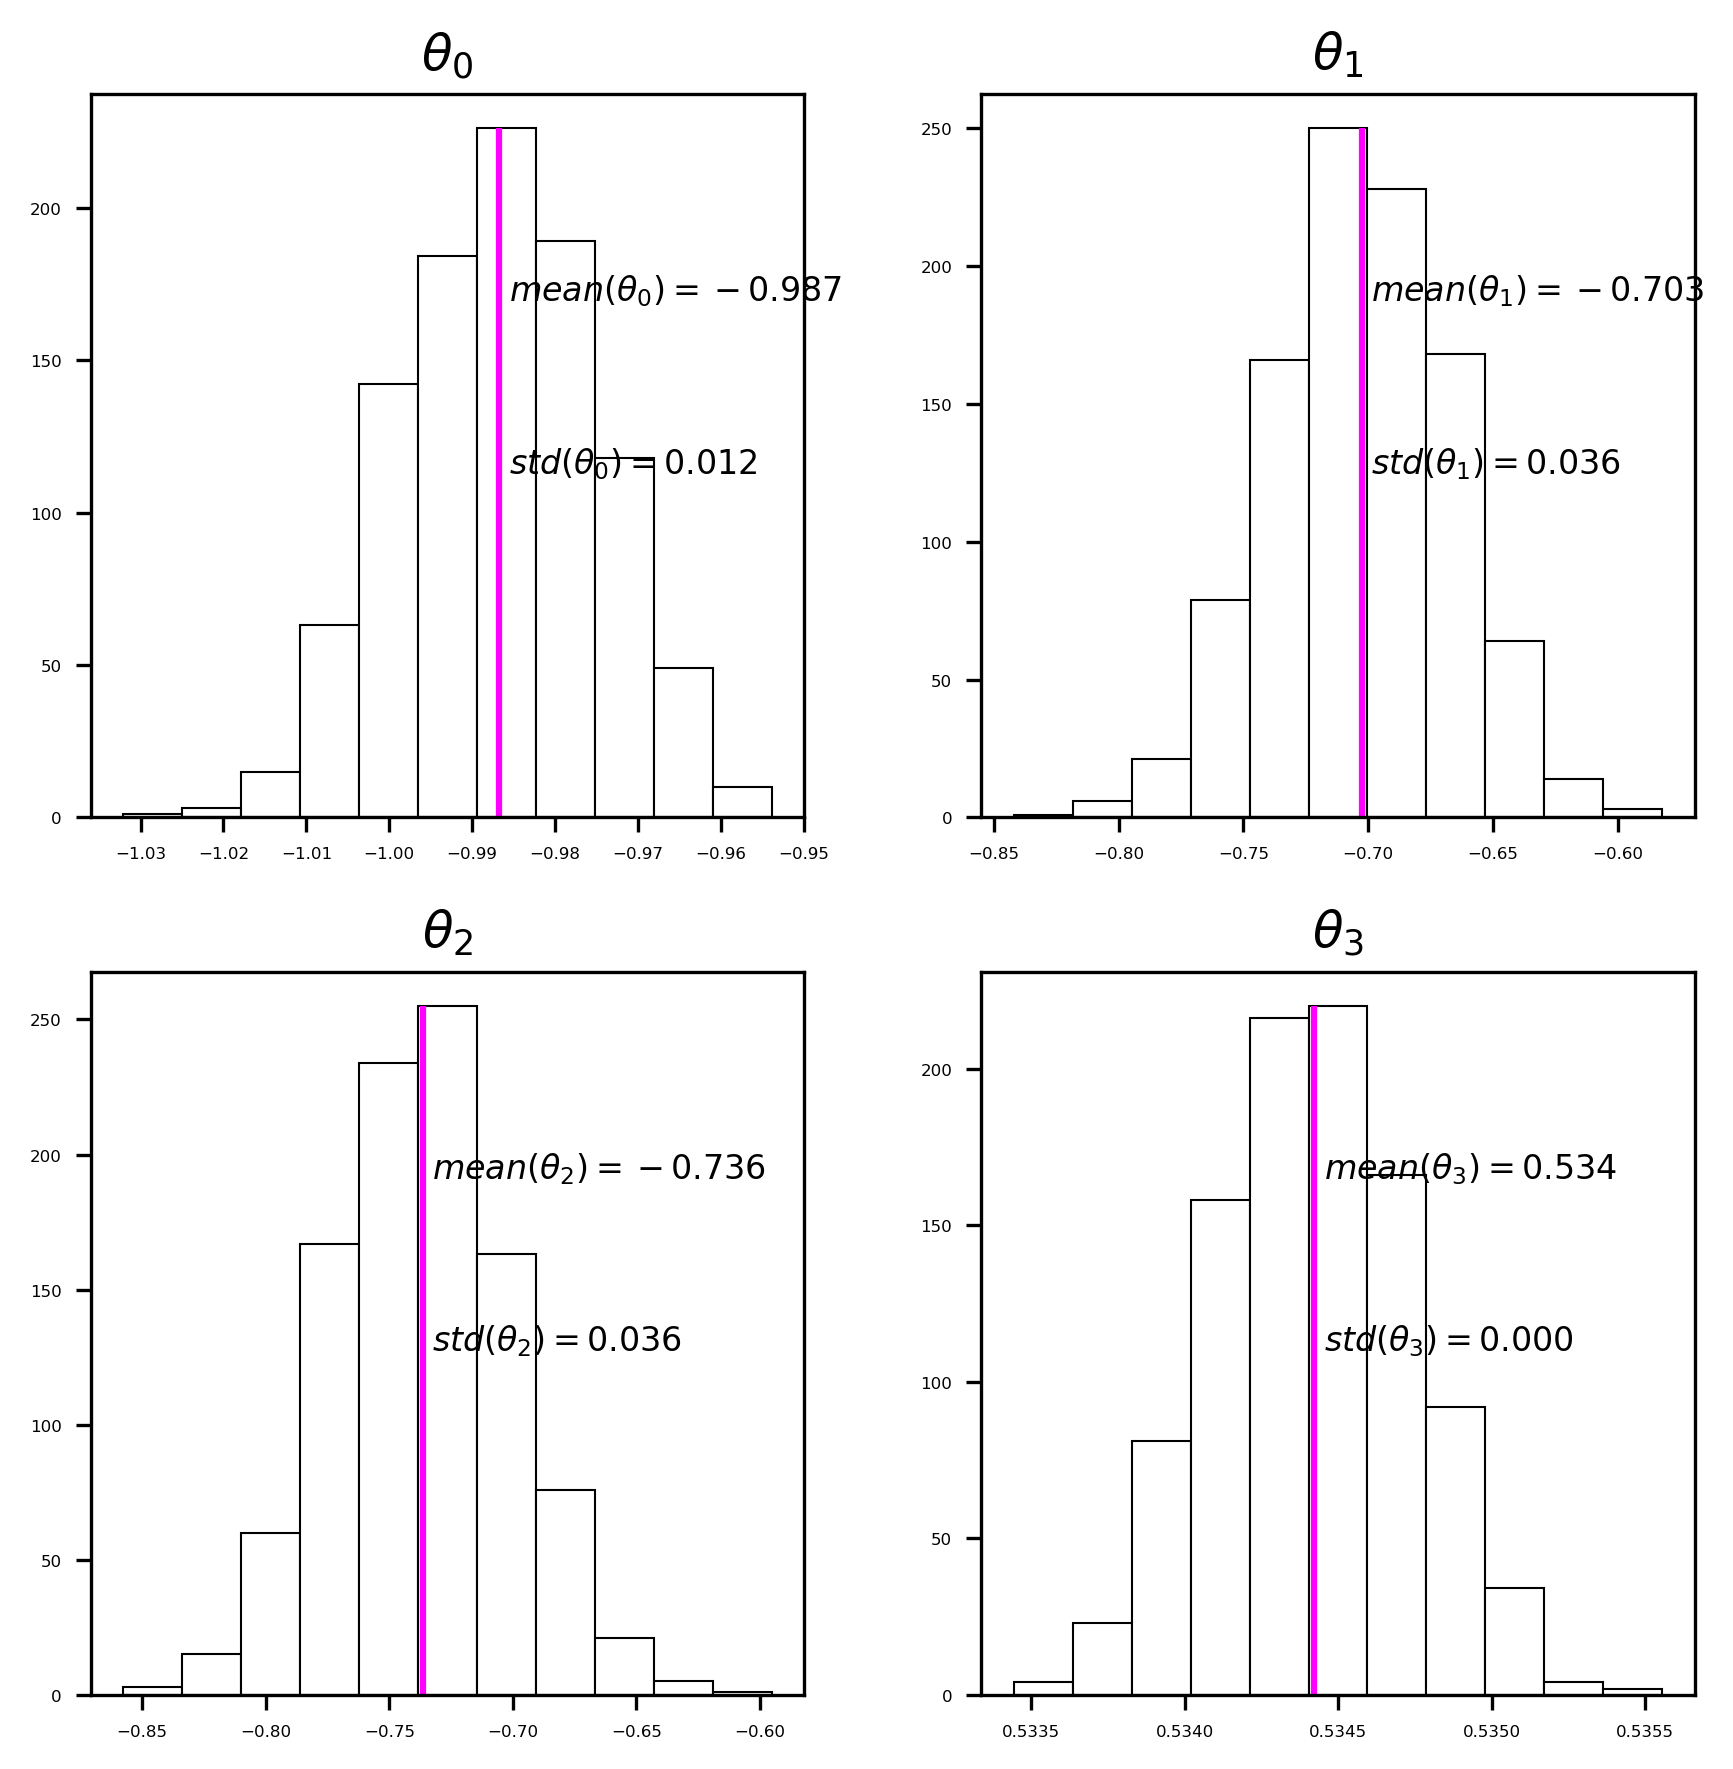

In [168]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(4):
    plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=11, color='white', ec="black", linewidth=0.5)
    plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
plt.tight_layout()

In [109]:
sample_size = 100
theta_values_curr_sample_size = []
for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13363.70it/s]


In [110]:
theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
theta_values_curr_sample_size.shape

(1000, 5)

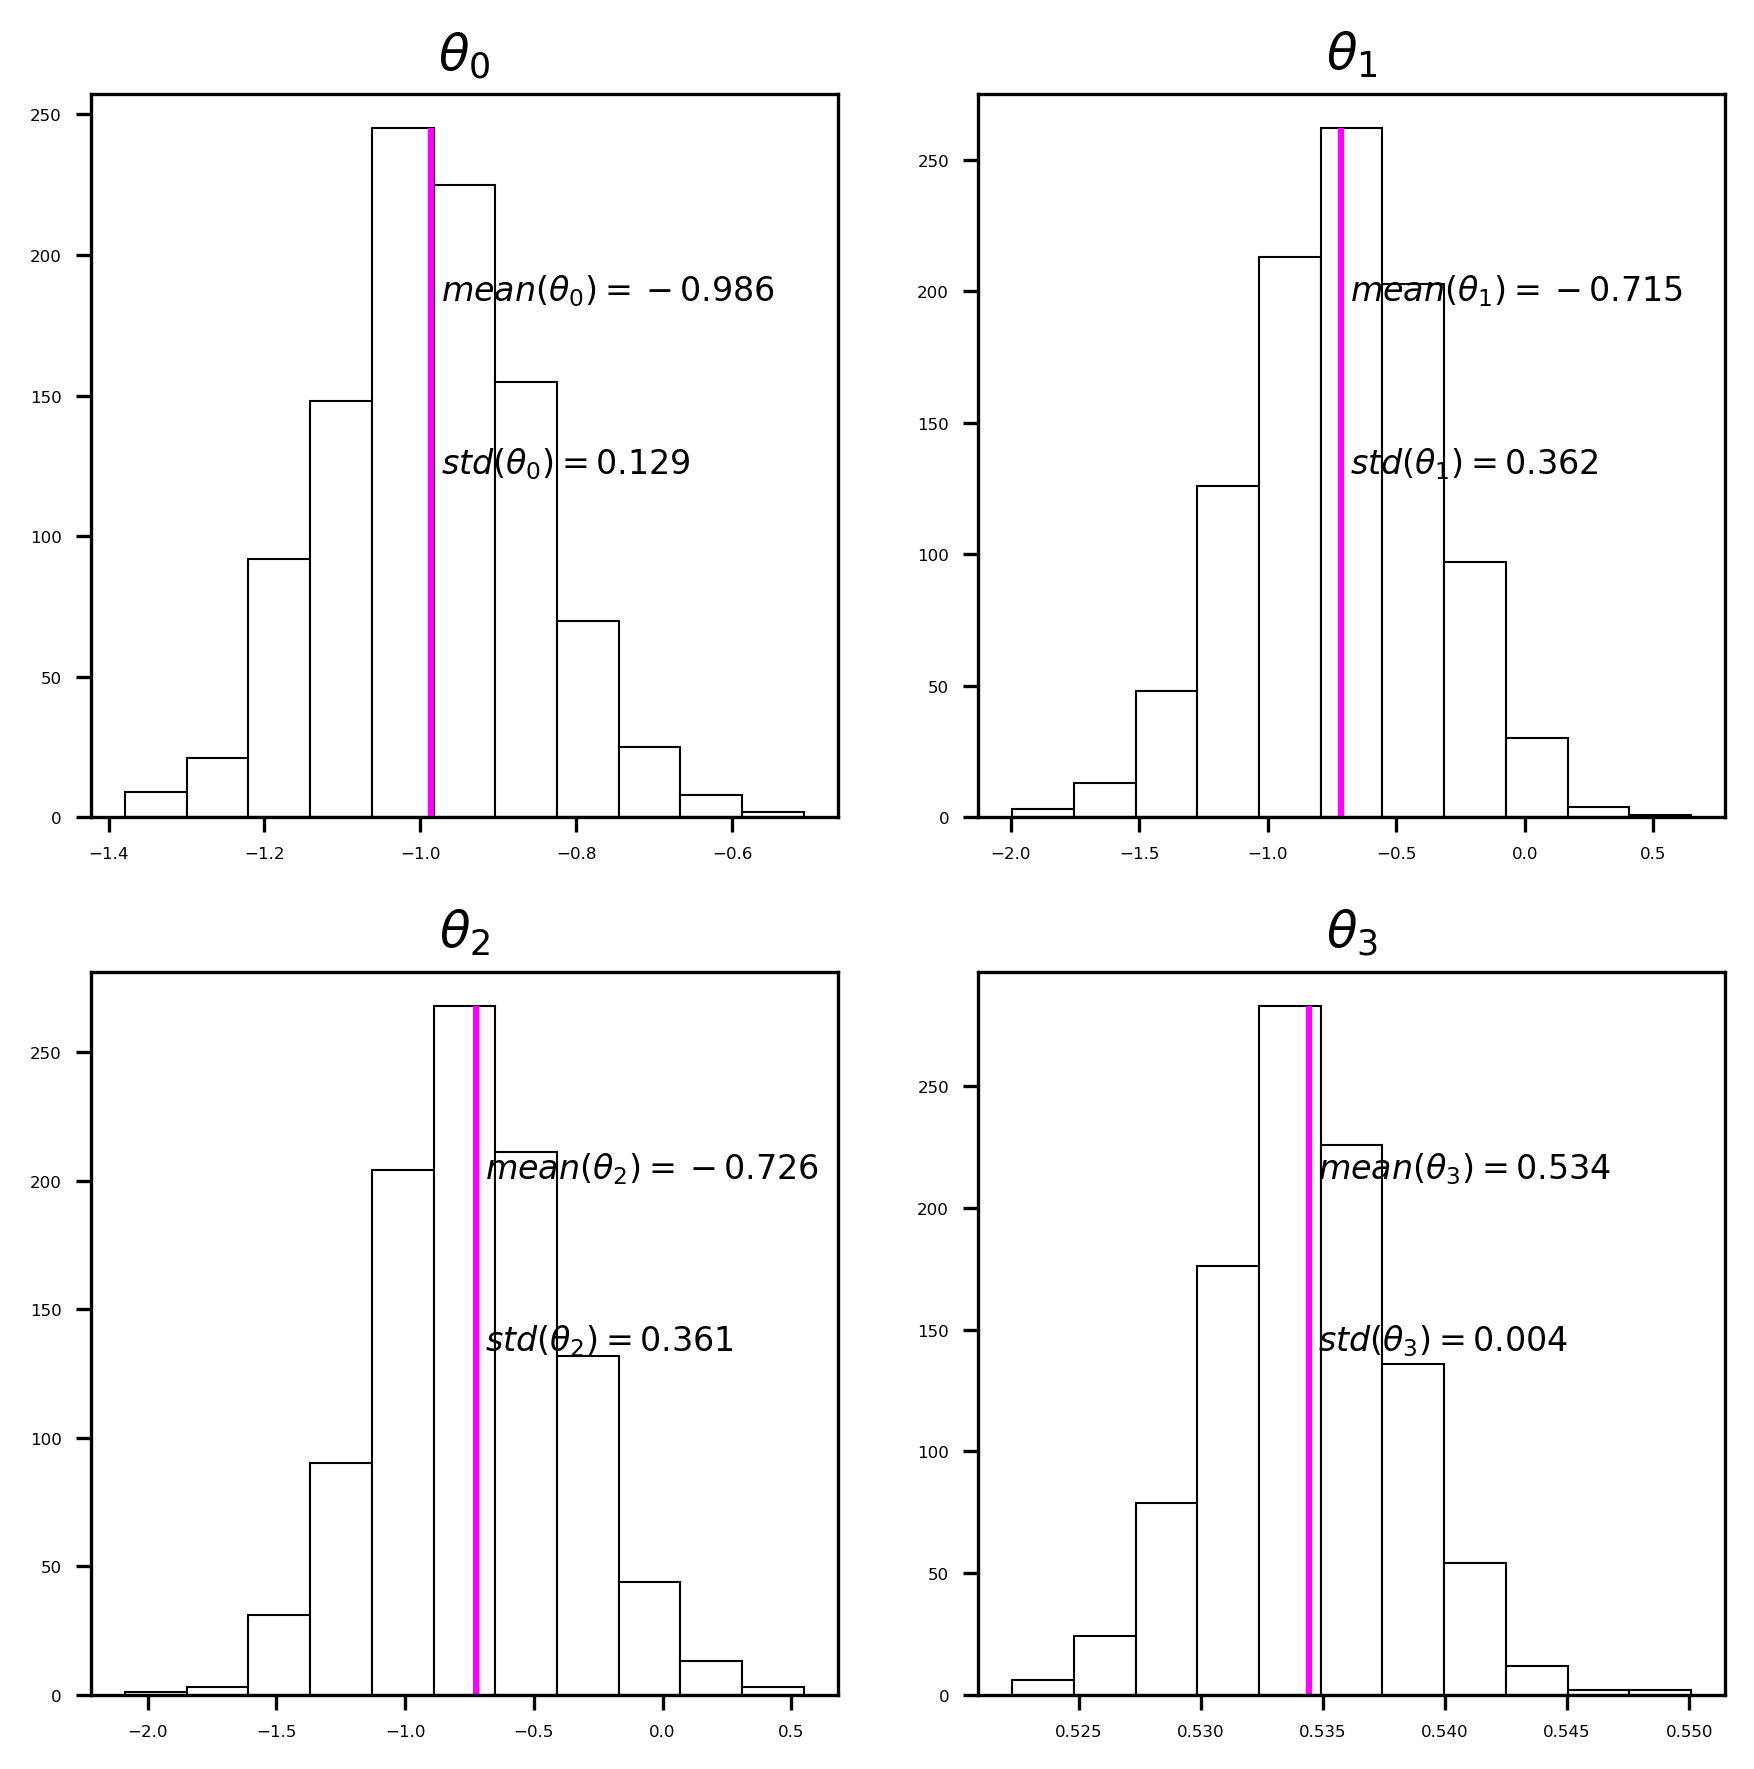

In [111]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(4):
    plt.subplot(2,2, i+1)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=11, color='white', ec="black", linewidth=0.5)
    plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
plt.tight_layout()

In [112]:
sample_size = 200
theta_values_curr_sample_size = []
for i in tqdm(range(B), total=B):
    Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
    lr = linear_regression()
    lr.fit(Xtrain,ytrain)
    theta_values_curr_sample_size.append(np.copy(lr.theta))

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12533.44it/s]


На основании величины неопределенности параметров, указанных на графиках выше, можно сделать вывод о достаточности данных для оценки параметров модели

## Неопределенность параметров в зависимости от размера bootstrap-выборки


In [113]:
# Построим график зависимости  std(𝜃) от N для заданных значений N.
theta_values_per_sample_size = []
#test_range_for_bs = [10, 20, 25, 30, 35, 40, 50]
test_range_for_bs = [10, 25, 50, 100, 200, 500, 1000, 2000, 4000, 10000]
for sample_size in test_range_for_bs:
    theta_values_curr_sample_size = []
    for i in tqdm(range(B), total = B):
        X_train, y_train = sample_bootstrap(X, y, sample_size = sample_size)
        lr = linear_regression()
        lr.fit(X_train,y_train)
        theta_values_curr_sample_size.append(np.copy(lr.theta))
    theta_values_curr_sample_size = np.concatenate([t.T for t in theta_values_curr_sample_size], axis=0)
    theta_values_per_sample_size.append({'sample_size': sample_size, 'theta_values': theta_values_curr_sample_size})

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1235.14it/s]


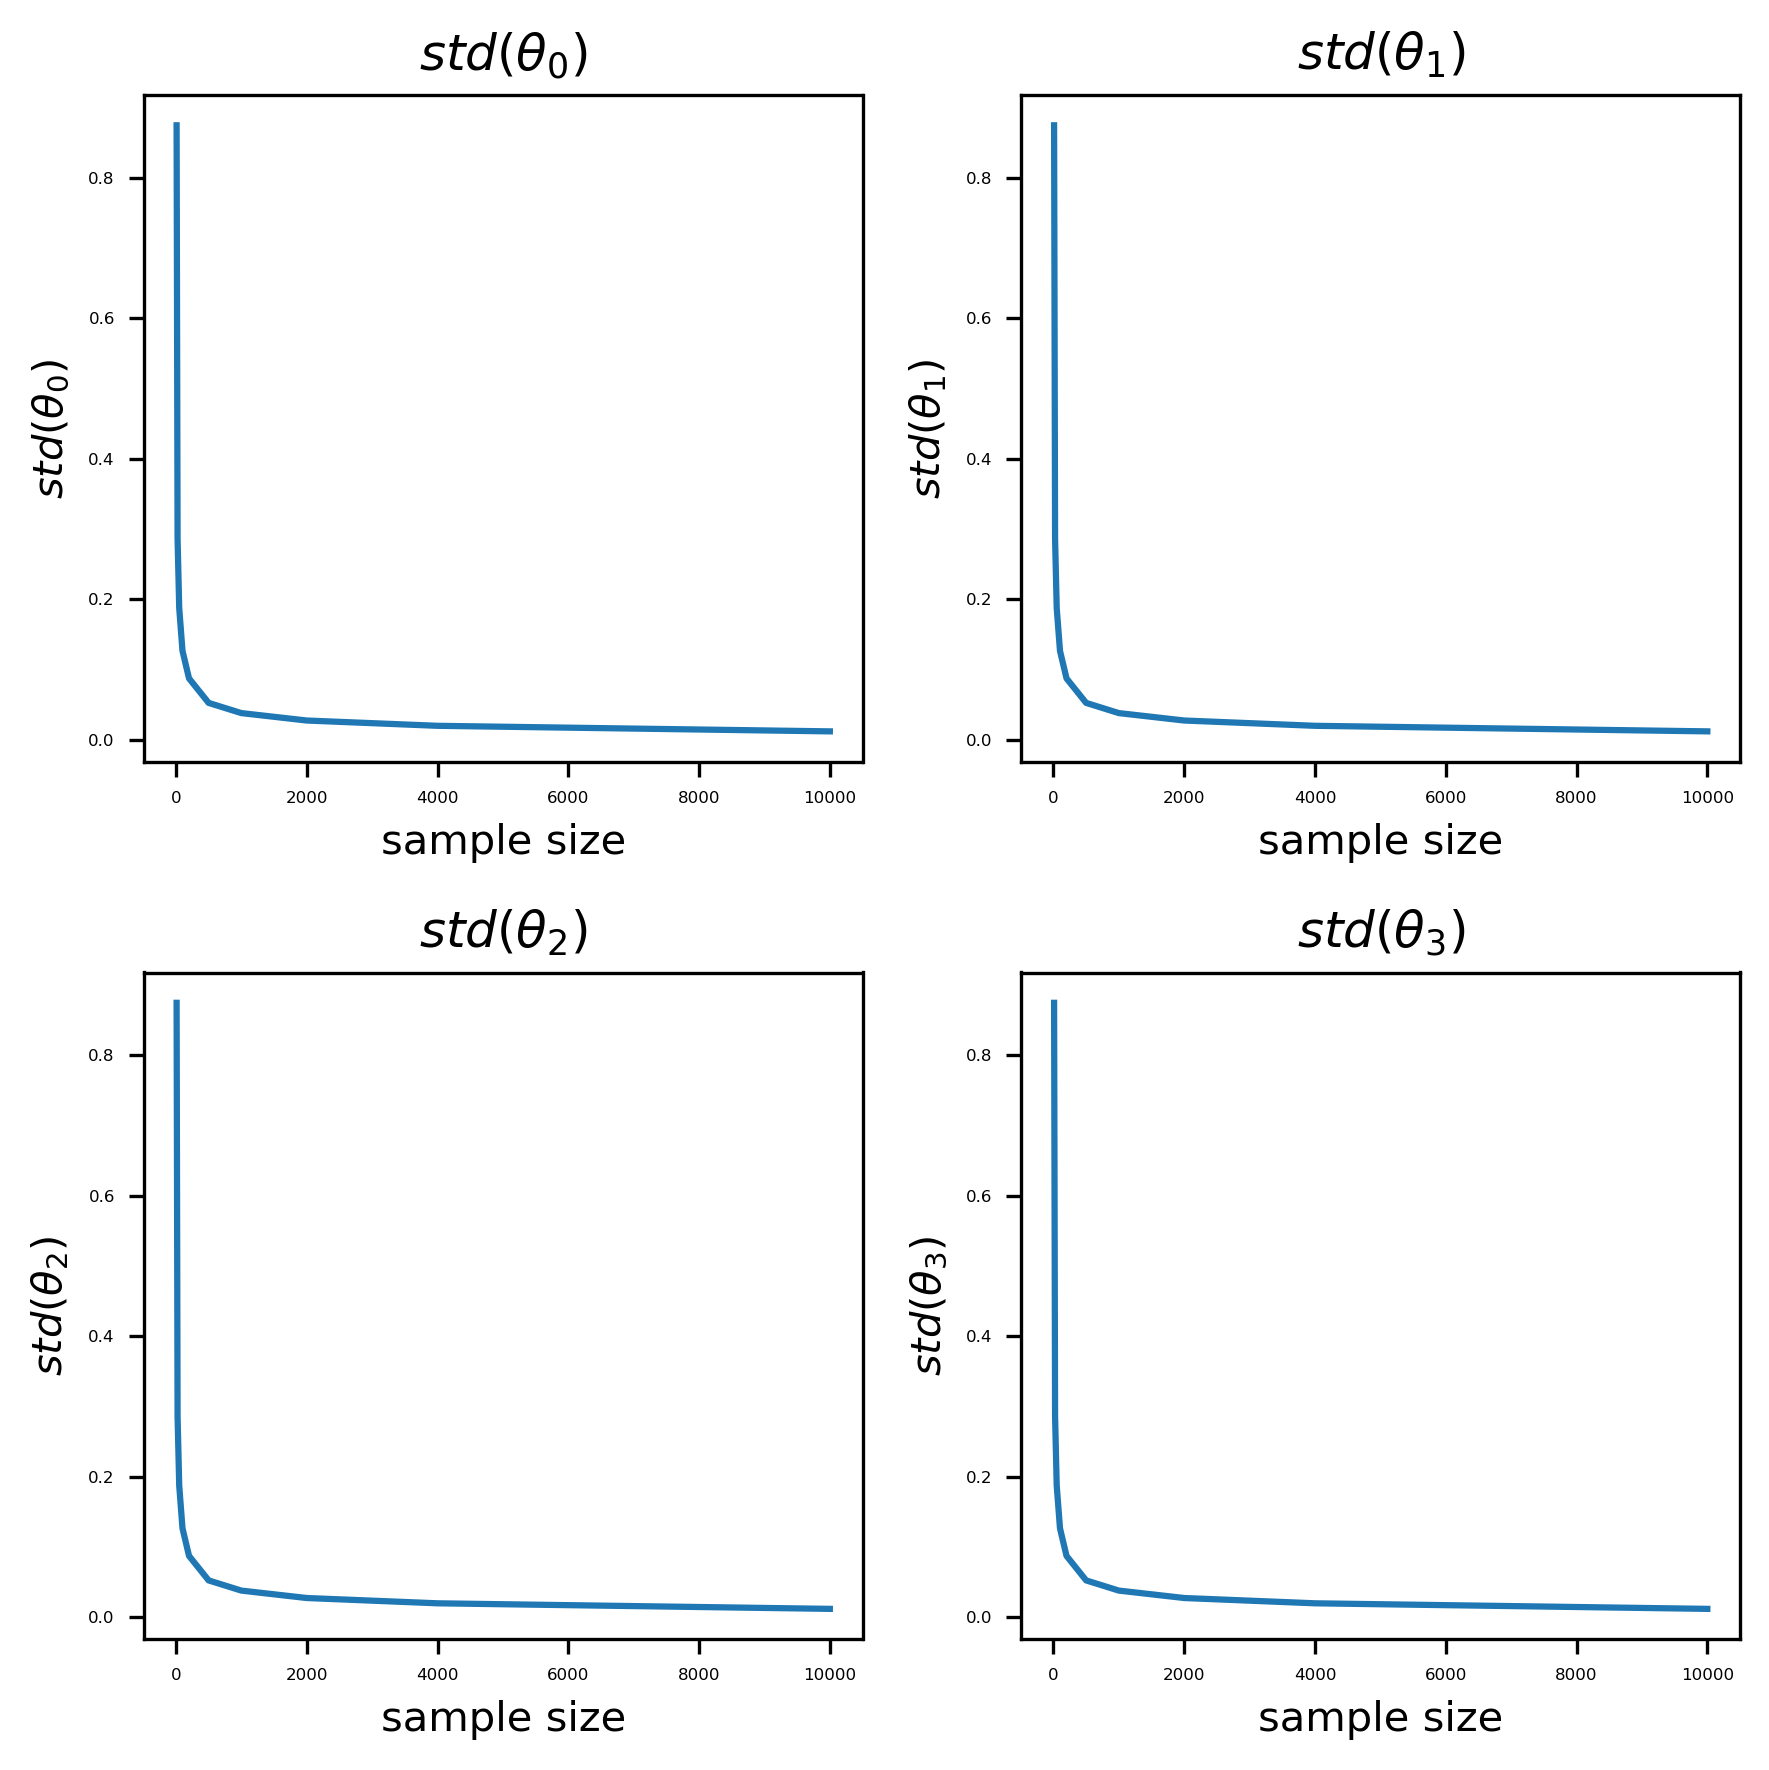

In [114]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(4):
    _ = plt.subplot(2,2,i+1)
    _ = plt.plot([t['sample_size'] for t in theta_values_per_sample_size],
                 [np.std(t['theta_values'][:,0]) for t in theta_values_per_sample_size],
                 label='$std(\\theta_%d)$' % i)
    _ = plt.ylabel('$std(\\theta_%d)$' % i)
    _ = plt.xlabel('sample size')
    _ = plt.title('$std(\\theta_%d)$' % i)
plt.tight_layout()

In [115]:
# Начиная с размера выборки, равной 2000, мера качества начинает насыщаться.

## 5) Исследование на предмет оптимального количества bootstrap-выборок с точки зрения неопределенности оценки параметров модели

In [116]:
#Доверительный интервал | По условию составляет 95%. То есть это такой интервал в окрестности среднего значения распределения нашей величины, в который попадут 95% измерений.

In [117]:
# Мы зафиксировали Nb = 2000, подберем параметр B

In [159]:
best_B = None
best_sz = 2000
best_std_values = {}
std_values = {}
for B in tqdm(range(10, 1000, 10)):
    cur_std_values = {}
    theta_values_curr_B = {}
    for i in range(B):
        X_, y_ = sample_bootstrap(X_train, y_train, sample_size=best_sz)
        lr = linear_regression()
        lr.fit(X_, y_)
        
        if theta_values_curr_B == {}:
            for i in range(len(lr.theta)):
                theta_values_curr_B[i] = []
                
        if best_std_values == {}:
            for i in range(len(lr.theta)):
                best_std_values[i] = np.inf
    
        for i in range(len(lr.theta)):
                theta_values_curr_B[i].append(lr.theta[i][0])
    
    flag = True
    for key in theta_values_curr_B:
        cur_std_values[key] = np.std(theta_values_curr_B[key])
        if cur_std_values[key] > best_std_values[key]:
            flag = False
      
    std_values[B] = cur_std_values
    
    if flag == True:
        for key in cur_std_values:
            best_std_values[key] = cur_std_values[key]
            best_B = B

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:11<00:00,  8.44it/s]


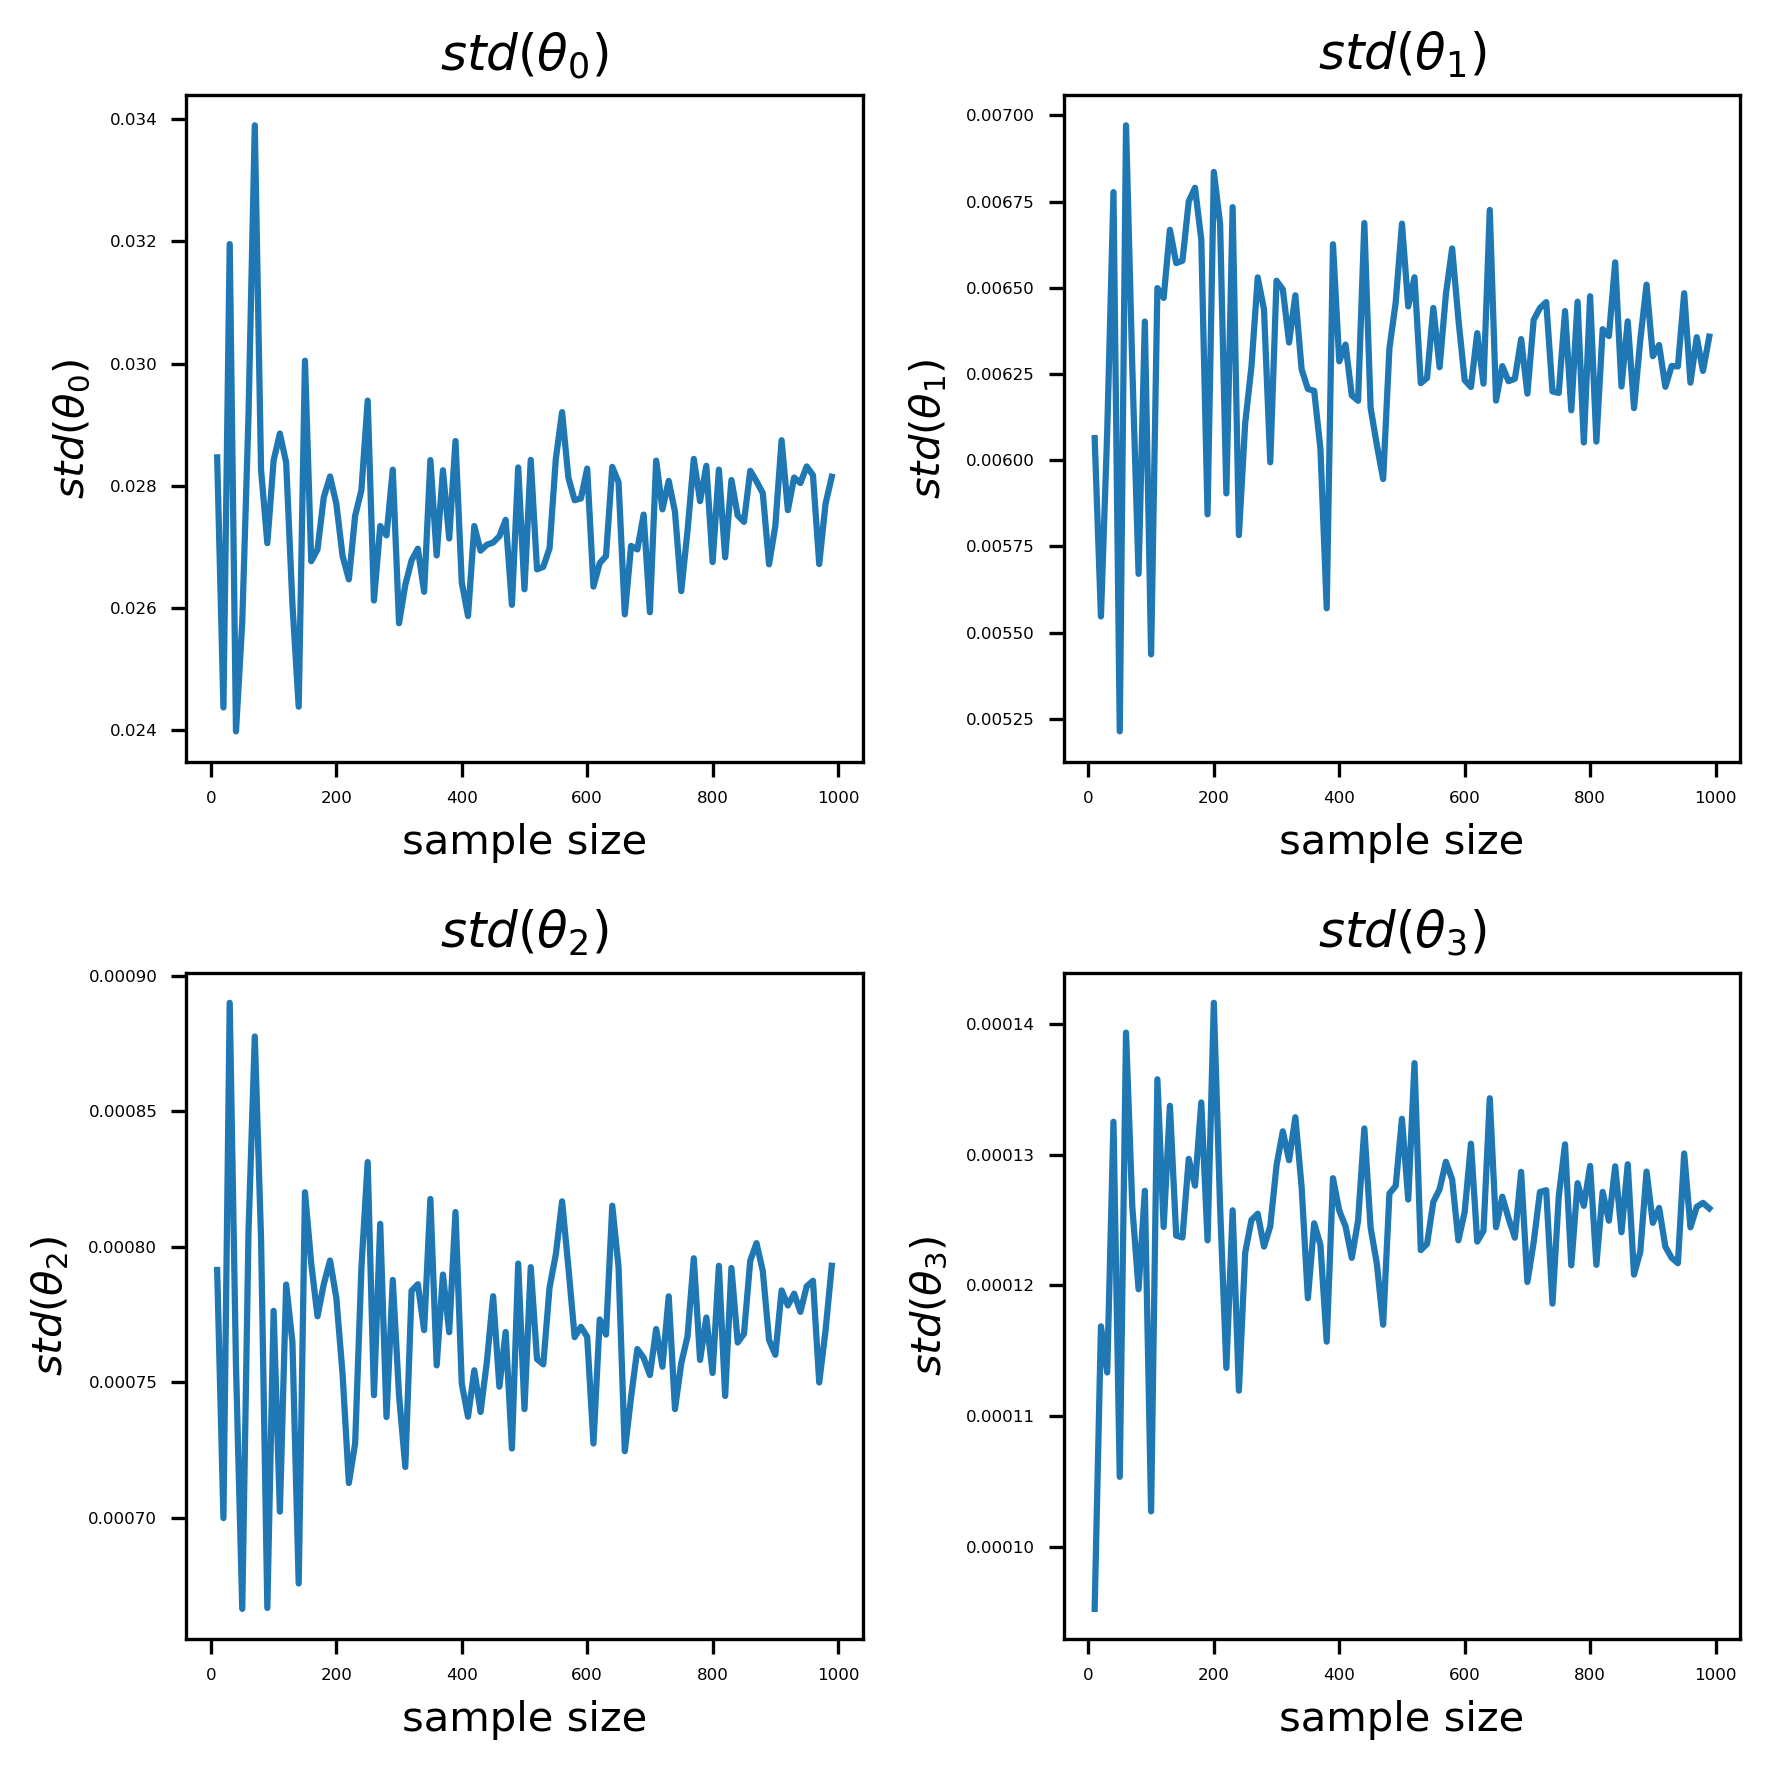

In [160]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(4):
    _ = plt.subplot(2,2,i+1)
    _ = plt.plot(list(range(10, 1000, 10)),
                 [std_values[key][i] for key in std_values],
                 label='$std(\\theta_%d)$' % i)
    _ = plt.ylabel('$std(\\theta_%d)$' % i)
    _ = plt.xlabel('sample size')
    _ = plt.title('$std(\\theta_%d)$' % i)
plt.tight_layout()

In [162]:
print(f'Оптимальное количество выборок: {best_B}')

Оптимальное количество выборок: 10


## Оценка качества модели

In [163]:
#надо расчитать MSE (сред.кв.ош),сделаем оценку
lr = linear_regression()
lr.fit(X,y)
theta = lr.theta
#ф-ия потерь для обуч нобора
y_learn = lr.predict(X)
mean_error_0 = np.mean(y-y_learn)
MSE_0 = np.std((y-y_learn))
print(mean_error_0)
print(MSE_0)

1.4352963262354025e-15
0.726777990016244


In [164]:
#Сравним функцию ошибок от бутстрап-выборки с такой же от тестовой выборки.
random_ind = np.random.permutation(X.shape[0])
random_index = random_ind[:150]

X_test = np.squeeze(X[[random_index],:])
X_00 = np.ones((X_test.shape[0], 1))
y_test = y[random_index]

y_pred = lr.predict(X_test)
MSE_test = np.std((y_pred-y_test))
print(MSE_test)

0.7029354739965562


In [35]:
# оценим неопредленность качества модели
Nb=2000
B=10

Визуализация распределения (распределений) оценок параметров. Оранжевым цветом выделен доверительный интервал с уровнем доверия 0.95

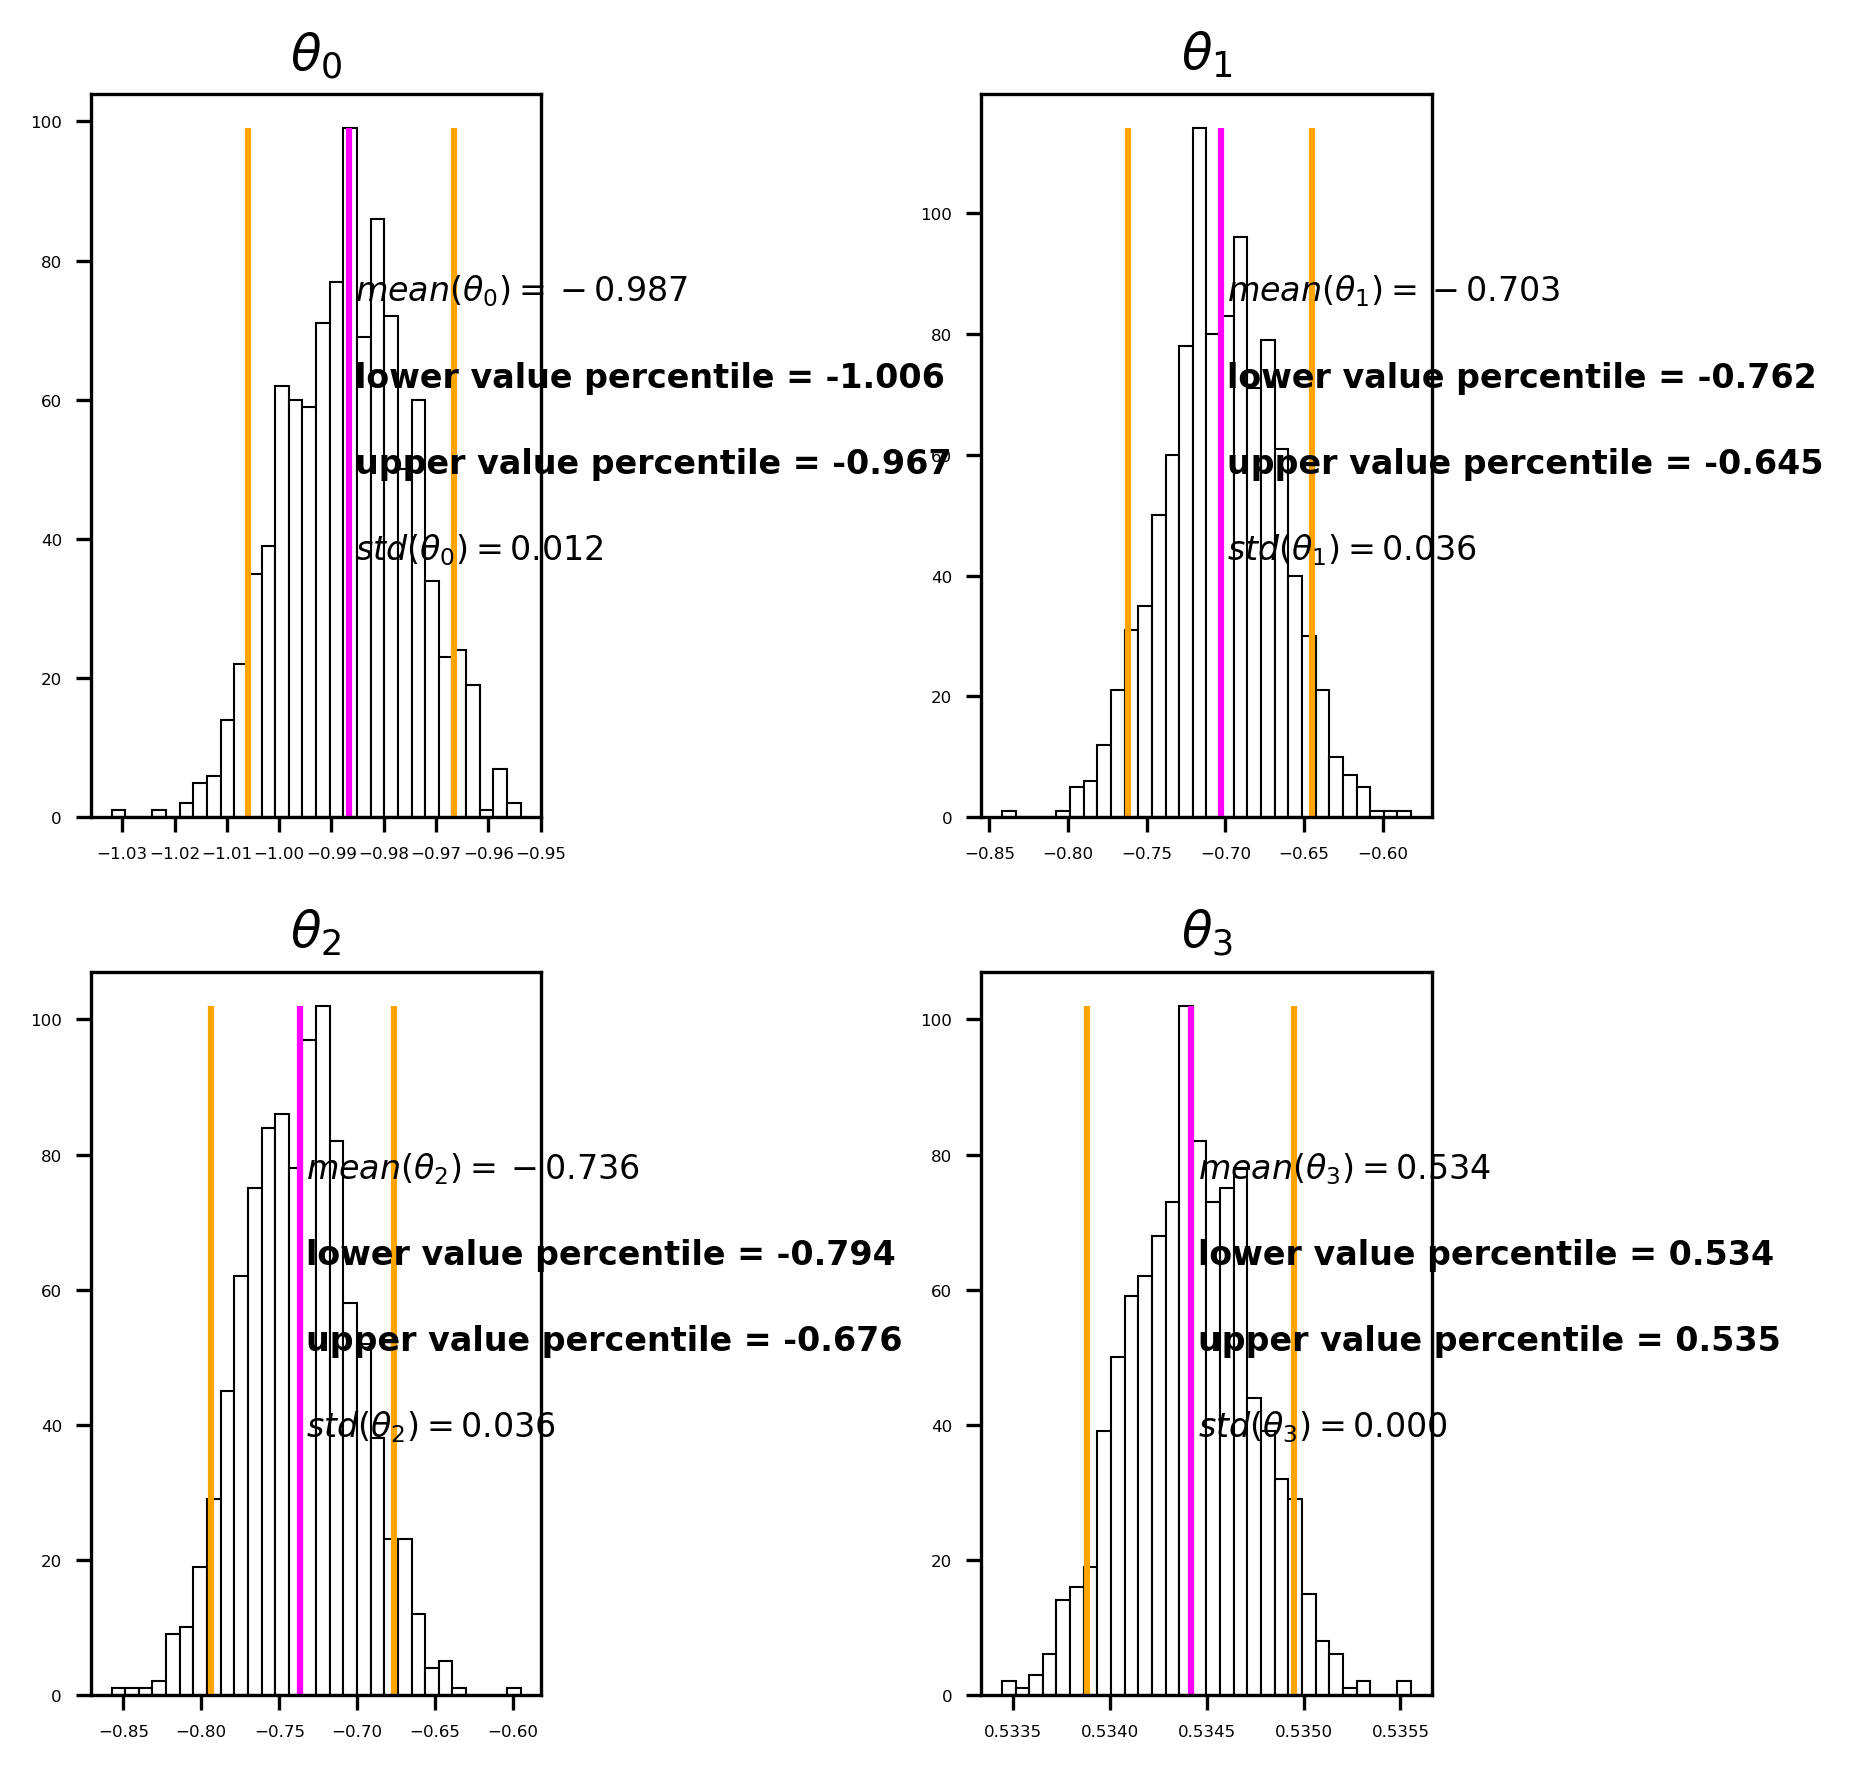

In [165]:
f = plt.figure(figsize=(6,6), dpi=300)
for i in range(4):
    _ = plt.subplot(2,2, i+1)
    upper = np.percentile(theta_values_curr_sample_size[:,i], 95)
    lower = np.percentile(theta_values_curr_sample_size[:,i], 5)
    h_counts,h_bins,_ = plt.hist(theta_values_curr_sample_size[:,i], bins=30, color='white', ec="black", linewidth=0.5)
    _ = plt.title("$\\theta_%d$" % i)
    mean_theta_i = np.mean(theta_values_curr_sample_size[:,i])
    std_theta_i = np.std(theta_values_curr_sample_size[:,i])
    _ = plt.vlines(mean_theta_i, 0, h_counts.max(), color='magenta')
    _ = plt.vlines(upper, 0, h_counts.max(), color='orange')
    _ = plt.vlines(lower, 0, h_counts.max(), color='orange')
    _ = plt.text(mean_theta_i+std_theta_i/10, 3*h_counts.max()/4, '$mean(\\theta_%d) = %.3f$' % (i, mean_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 1.5*h_counts.max()/4, '$std(\\theta_%d) = %.3f$' % (i, std_theta_i), fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2*h_counts.max()/4, f'upper value percentile = {round(upper, 3)}', fontsize=8, weight='bold')
    _ = plt.text(mean_theta_i+std_theta_i/10, 2.5*h_counts.max()/4, f'lower value percentile = {round(lower, 3)}', fontsize=8, weight='bold')
_ = plt.tight_layout()

Оценка неопределенности качества модели: оценка доверительного интервала для качества модели с уровнем доверия 0.95

In [18]:
plot(mse_values, 'mse')

NameError: name 'plot' is not defined

## Аппроксимация целевой переменной на выборке вновь поступающих объектов

In [252]:
#X_inference

In [253]:
X_inference.shape

(100, 4)

In [254]:
X_inference_0 = np.ones((X_inference.shape[0],1))
X_inference_new = np.concatenate([X_inference_0, X_inference], axis = 1)
Y_inference_approximated = np.dot(X_inference_new, theta)

No handles with labels found to put in legend.


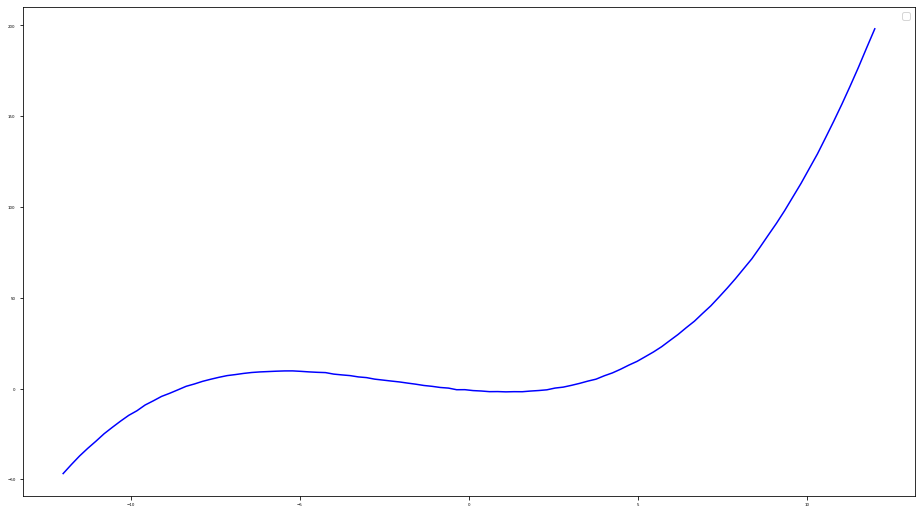

In [268]:
fig = plt.figure(figsize=(16, 9))
P = plt.plot(X_inference_new[:, 1], Y_inference_approximated, color = 'blue')
P = plt.legend()


No handles with labels found to put in legend.


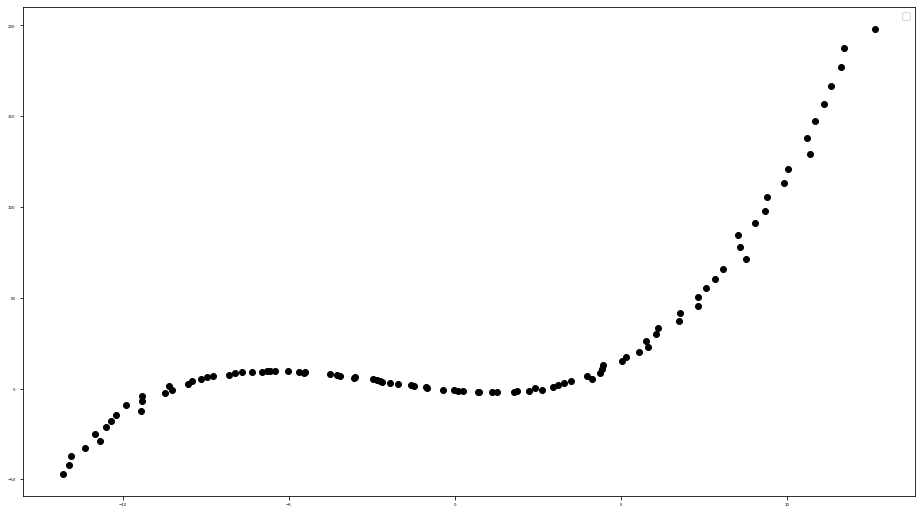

In [259]:
fig = plt.figure(figsize=(16, 9))
plt.scatter(X_inference_new[:, 2], Y_inference_approximated, color = 'black')
plt.legend()

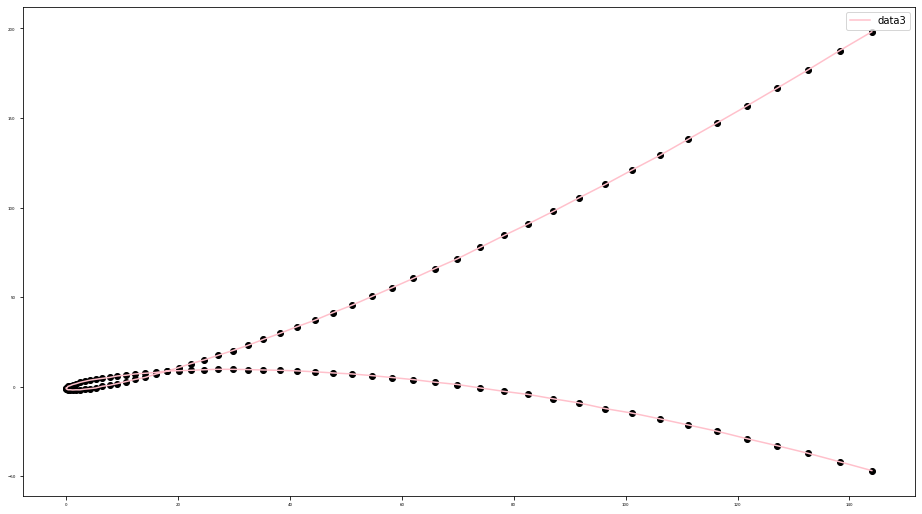

In [256]:
fig = plt.figure(figsize=(16, 9))
plt.plot(X_inference_new[:, 3], Y_inference_approximated, color = 'pink', label = 'data3')
plt.scatter(X_inference_new[:, 3], Y_inference_approximated, color = 'black')
plt.legend()

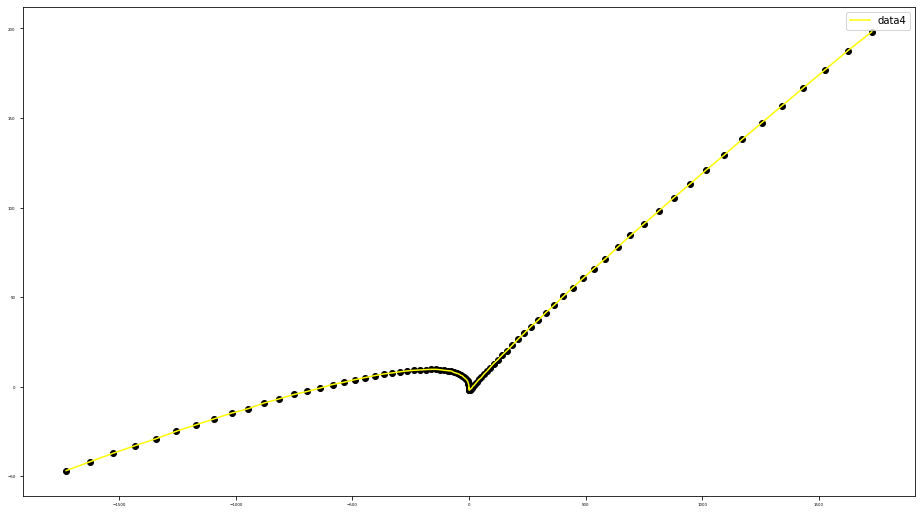

In [257]:
fig = plt.figure(figsize=(16, 9))
plt.plot(X_inference_new[:, 4], Y_inference_approximated, color = 'yellow', label = 'data4')
plt.scatter(X_inference_new[:, 4], Y_inference_approximated, color = 'black')
plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1419.38it/s]


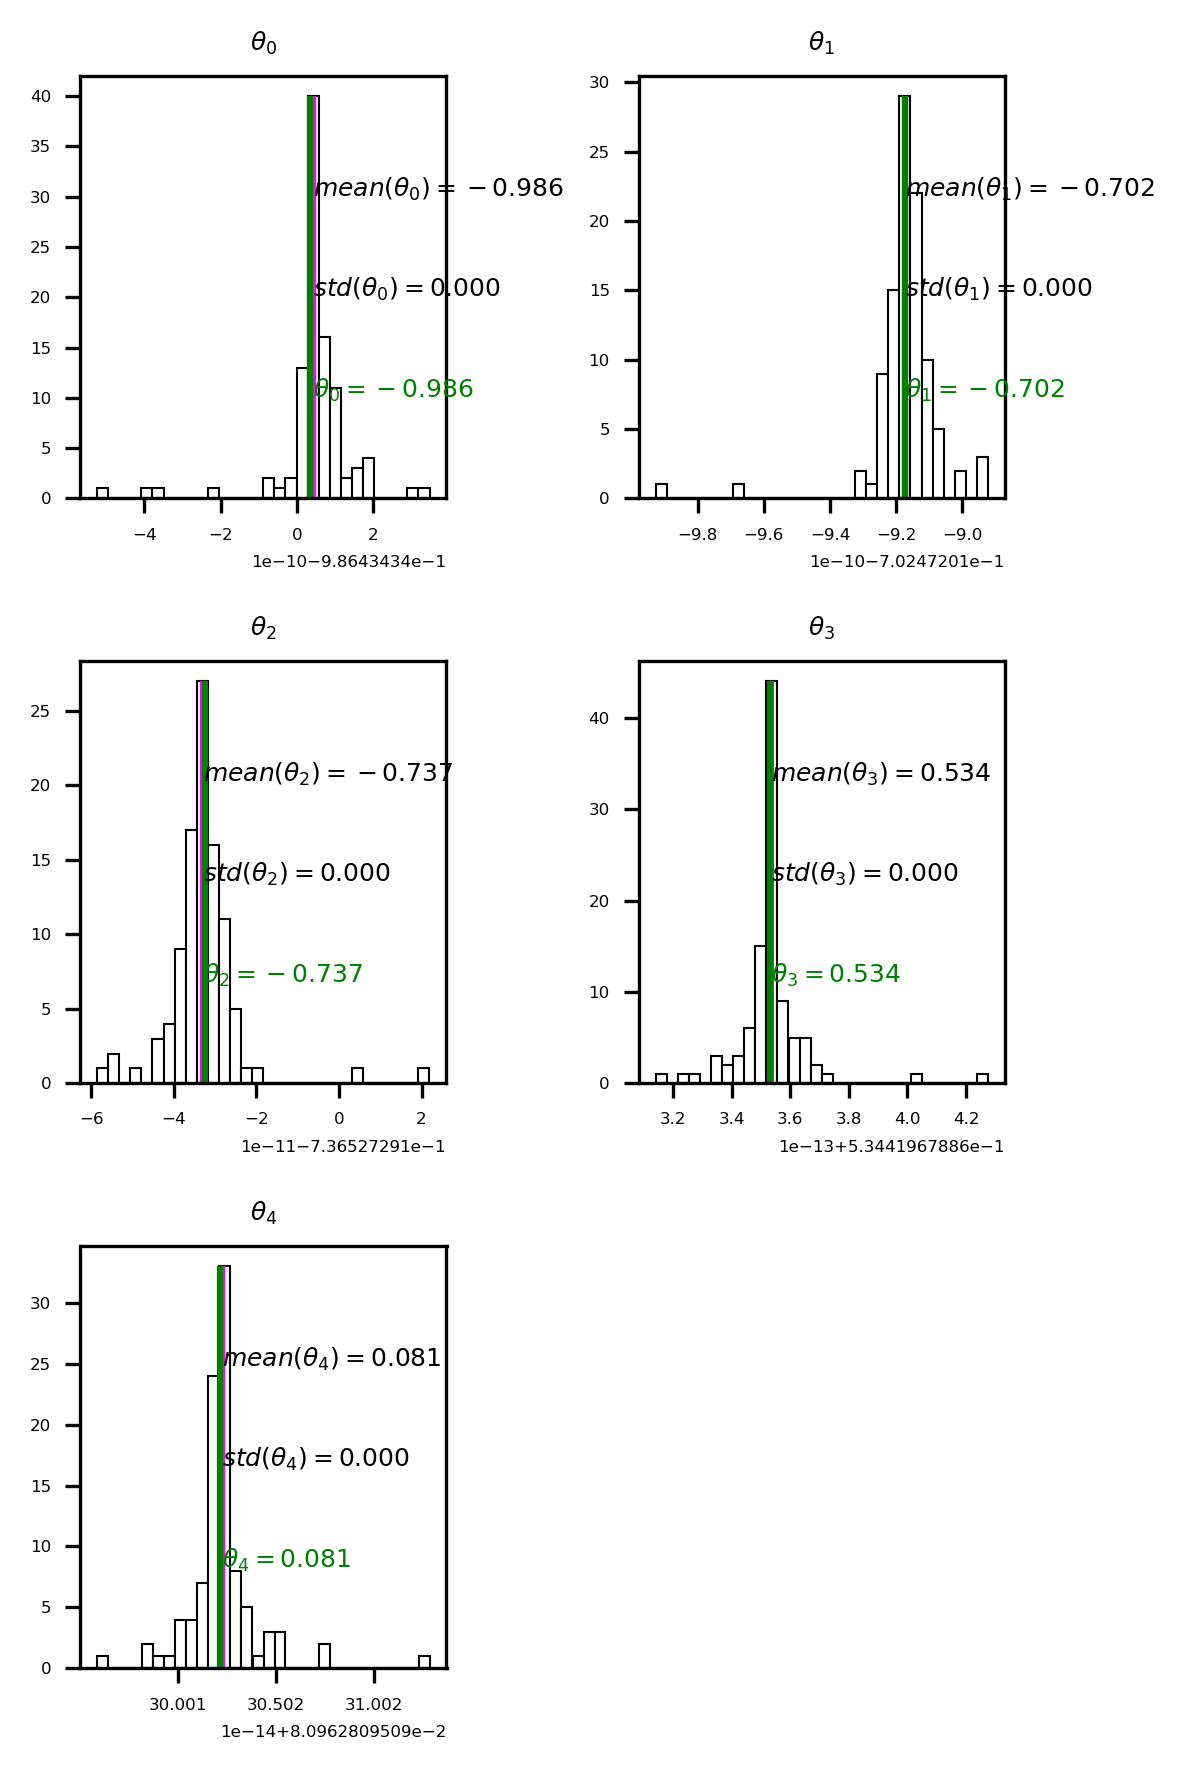

In [269]:
P = bootstrap_sample_size_plot(X_inference, Y_inference_approximated, 100, 10)